In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from math import sqrt
from pytz import timezone

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, Normalizer, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Input
from keras.utils.np_utils import to_categorical
from keras import optimizers
import keras
import talib
from fractions import gcd
import time

import pywt
from statsmodels.robust import stand_mad
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
fig_size = (12, 9)
plt.rcParams["figure.figsize"] = fig_size

In [64]:
def get_CU():
    import dovahkiin as dk
    dp = dk.DataParser()
    X = dp.get_data("cu")
    return X

def get_SP500():
    import pandas_datareader as pdr    
    SP500 = pdr.get_data_yahoo('^GSPC')
    return SP500

def get_X_data(time_interval):
    import dovahkiin as dk
    dp = dk.DataParser()
    X = dp.get_data("cu", split_threshold=time_interval)
    return X

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalise_window = []
        if (window[0]==0):
            normalised_window = [0 for p in window]
        else:
            normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def build_model(layers, with_regularizer=None, dropout=0.2):
    model = Sequential()
    
    total_lstm_layers = len(layers) - 3 # substract the first (input size), fisrt layer and last layer
    assert(total_lstm_layers > 0)
    
    print("> Using regularizer: {}".format(with_regularizer))

    model.add(LSTM(
        input_shape=(layers[1], layers[0]),
        output_dim=layers[1],
        return_sequences=True,
        kernel_regularizer=with_regularizer,
        recurrent_regularizer=with_regularizer,
        bias_regularizer=with_regularizer,
        dropout=dropout,
        recurrent_dropout=dropout))
    
    for i in range(total_lstm_layers):
        model.add(LSTM(
            layers[i+2],
            return_sequences=(i<total_lstm_layers-1),
            kernel_regularizer=with_regularizer,
            recurrent_regularizer=with_regularizer,
            bias_regularizer=with_regularizer,
            dropout=dropout,
            recurrent_dropout=dropout))

    model.add(Dense(
        output_dim=layers[-1]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    return model

def build_stateful_model(layers, with_regularizer=None, dropout=0.2, batch_size=1):
    model = Sequential()
    
    total_lstm_layers = len(layers) - 3 # substract the first (input size), fisrt layer and last layer
    assert(total_lstm_layers > 0)
    
    print("> Using regularizer: {}".format(with_regularizer))

    model.add(LSTM(
        batch_input_shape=(batch_size, layers[1], layers[0]),
        output_dim=layers[1],
        return_sequences=True,
        stateful=True,
        kernel_regularizer=with_regularizer,
        recurrent_regularizer=with_regularizer,
        bias_regularizer=with_regularizer,
        dropout=dropout,
        recurrent_dropout=dropout))
    
    for i in range(total_lstm_layers):
        model.add(LSTM(
            layers[i+2],
            stateful=True,
            return_sequences=(i<total_lstm_layers-1),
            kernel_regularizer=with_regularizer,
            recurrent_regularizer=with_regularizer,
            bias_regularizer=with_regularizer,
            dropout=dropout,
            recurrent_dropout=dropout))

    model.add(Dense(
        output_dim=layers[-1]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    return model

def predict_point_by_point(model, data, stateful=False):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    if stateful:
        predicted = model.predict(data, batch_size=1)
    else:
        predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def timeseries_to_supervised(raw_time_series, lag):
    p = {}
    for i in range(1, lag+1):
        p["{}".format(i)] = raw_time_series.shift(i).fillna(0)
    p["0"] = raw_time_series
    
    supervised_data = pd.Panel(p)
    return supervised_data

def non_shuffling_train_test_split(X, y, test_size=0.2):
    i = int((1 - test_size) * X.shape[0]) + 1
    X_train, X_test = np.split(X, [i])
    y_train, y_test = np.split(y, [i])
    return X_train, X_test, y_train, y_test

def create_supervised_X(raw_time_series, lag):
    supervised_X = timeseries_to_supervised(raw_time_series, lag)
    swaped_supervised_X = supervised_X.swapaxes(0, 1)
    return swaped_supervised_X

def denormalize(X, predicted, look_back):
    prices = pd.DataFrame(X["HLC"]["2016":])
    base = X["HLC"].reset_index(drop=True)
    result = []
    for i in range(len(predicted)):
        result.append(base[-len(predicted)-look_back:].values[i] * (predicted[i] + 1))
    predicted_prices = np.array(result)
    prices["Predict"] = predicted_prices
    return prices

def directional_Accuracy(result):
    direction_prediction = (result.pct_change() <= 0)
    result = accuracy_score(direction_prediction["HLC"], direction_prediction["Predict"])
    return result

def load_data(X, 
              X_train_begin=2012, 
              X_train_end=2015, 
              normalise_window=True, 
              look_back=4, 
              UseLSTM=True,
              wavelet_denoising=False,
              useTechnicalIndicators=False,
              encoder=None
             ):
    
    #Divide Data into Train and Test
    train_begin_time = "{}".format(X_train_begin)
    train_end_time = "{}".format(X_train_end)
    test_begin_time = "{}".format(X_train_end+1)
    
    X["HLC"] = (X.high + X.low + X.close) / 3
    
    if wavelet_denoising:
        X["denoisedHLC"] = WaveletTransform(X)
        denoised = X["denoisedHLC"].reset_index(drop=True).values
    train_id = len(X[:train_end_time])
    prices = X["HLC"].reset_index(drop=True).values
    data_sequence = []
    for i in range(len(prices)):
        if (i - look_back) < 0:
            data_sequence.append([0 for i in range(look_back+1)])
        else:
            if wavelet_denoising:
                data_sequence.append(np.append(denoised[i-look_back:i], prices[i]))
            else:
                data_sequence.append(prices[i-look_back:i+1])
        
    assert(len(data_sequence) == len(X))
    
    if normalise_window:
        data_sequence = normalise_windows(data_sequence)
    
    data_sequence = np.array(data_sequence)
    
    # the first look_back period doesn't have X_train, y_train
    train_data = data_sequence[look_back:train_id,]
    
    np.random.shuffle(train_data)

    X_train = train_data[:, :-1]
    X_test = data_sequence[train_id:, :-1]
    
    print("Test:  {}".format(len(X_test)))
    print("Train: {}".format(len(X_train)))

    y_train = train_data[:, -1]
    y_test  = data_sequence[train_id:, -1]        
    
    if UseLSTM:
        # LSTM expects a 3 dimensional vector. In our case, we have only one feature.
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  
        
    if useTechnicalIndicators:
        assert(encoder is not None)
        
        X = AddTechnicalIndicators(X)
        encoded_X = EncodingTechnicalIndicators(X, encoder, lookback=look_back)
        encoded_X = PrepareEncodingForLSTM(encoded_X, look_back=look_back)
        encoded_X_train = encoded_X[:train_id-look_back]
        encoded_X_test = encoded_X[train_id-look_back:]
        
        print("> X_train shape is {}".format(X_train.shape))
        print("> encoded_X_train shape is {}.".format(encoded_X_train.shape))
        print("> X_test shape is {}".format(X_test.shape))
        print("> encoded_X_test shape is {}.".format(encoded_X_test.shape))
        X_train = np.concatenate((X_train, encoded_X_train), axis=2)
        X_test = np.concatenate((X_test, encoded_X_test), axis=2)

    return [X_train, y_train, X_test, y_test]

def WaveletTransform(X, level=9, wavelet="haar"):
    isOdd = False
    if len(X) % 2 == 1:
        isOdd = True
    
    haar = pywt.Wavelet(wavelet)
    coeffs = pywt.wavedec(X["HLC"].values, haar, level=9)
    recomposed_return = pywt.waverec(coeffs, haar)

    # Wavelet De-noising
    sigma = stand_mad(coeffs[-1])
    uthresh = sigma*np.sqrt(2*np.log(len(X["HLC"].values)))
    denoised = coeffs[:]
    denoised[1:] = (pywt.threshold(i, value=uthresh) for i in denoised[1:])
    denoised_return = pywt.waverec(denoised, haar)
    if isOdd:
        X["denoisedHLC"] = denoised_return[:-1]
    else:
        X["denoisedHLC"] = denoised_return[:]

    diff = X["denoisedHLC"] - X["HLC"].values
    # correlation = np.corrcoef(denoised_return[:-1], X["HLC"].values)
    print("There are total of {} elements".format(len(X["denoisedHLC"])))
    # print("Total absolute difference: {}".format(np.abs(diff).sum()))
    # print("Correlation between denoised and original: {}".format(correlation[0][1]))
    return X["denoisedHLC"]

In [68]:
def AddTechnicalIndicators(X):
    high = X.high.values
    low = X.low.values
    close = X.close.values
    volume = X.volume.astype(np.float64).values
    
    # Min Max Scaler
    X["%K"], X["%D"] = talib.STOCHF(X.high.values, X.low.values, X.close.values)
    _, X["Slow %D"] = talib.STOCH(X.high.values, X.low.values, X.close.values)
    X["RSI"] = talib.RSI(close)
    X["WilliamsR"] = talib.WILLR(X.high.values, X.low.values, X.close.values)
    X["-DI"] = talib.MINUS_DI(high, low, close)
    X["+DI"] = talib.PLUS_DI(high, low, close)
    X["CMO"] = talib.CMO(close)
    X["AroonOSC"] = talib.AROONOSC(high, low)
    X["ADX"] = talib.ADX(high, low, close)
    X["AroonDown"], X["AroonUp"] = talib.AROON(high, low)
    X["ADXR"] = talib.ADXR(high, low, close)

    _top, _mid, _bot = talib.BBANDS(close)
    diff = _top - _bot
    diff[(_top - _bot) < 1] = 1
    X["%B"] = (X.close - _bot)/diff
    X["UltimateOscillator"] = talib.ULTOSC(high, low, close)
    X["MFI"] = talib.MFI(high, low, close, volume)
    
    return X

def EncodingTechnicalIndicators(X, encoder, lookback=32):
    X_train = X[:"2015"]
    X_test  = X["2016":]
    
    try:
        del X_train['open']
        del X_train['high'] 
        del X_train['low']
        del X_train['close']
        del X_train['volume']
        del X_train['openint']

        del X_test['open']
        del X_test['high'] 
        del X_test['low']
        del X_test['close']
        del X_test['volume']
        del X_test['openint']
        
        del X_train["HLC"]
        del X_test["HLC"]
    except:
        pass
    
    X_train.fillna(X_train.mean(), inplace=True)
    X_test.fillna(X_train.mean(), inplace=True)
    scaler = MinMaxScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    
    encoded_X = X_train.append(X_test)
    encoded_X = encoder.predict(encoded_X.values)
    
    return encoded_X

def PrepareEncodingForLSTM(X, look_back=32):
    result = []
    for i in range(len(X)):
        features = X[i]
        features_with_lookback = []
        if i < look_back:
            # pad with 
    #         for j in range(look_back):
    #             features_with_lookback.append(features)
            continue
        else:
            for j in range(look_back):
                features_with_lookback.append(X[i-look_back+j])
        result.append(features_with_lookback)
    result = np.array(result)
    return result

In [66]:
def train_deep_autoencoder(X_train, dim=8, batch_size=32, epochs=128):
    encoding_dim = dim # 54 dim -> 16 dim
    input_layer = Input(shape=(X_train.shape[1],))
    
    encoded = Dense(int(X_train.shape[1]), activation='relu')(input_layer)
    encoded = Dense(encoding_dim, activation='relu')(encoded)
    
    decoded = Dense(encoding_dim*2, activation='sigmoid')(encoded)    
    decoded = Dense(X_train.shape[1])(decoded)
    
    # this model maps an input to its reconstruction
    autoencoder = Model(input_layer, decoded)
    
    encoded_input = Input(shape=(encoding_dim,))
    encoder = Model(input_layer, encoded)
    
    decoder_layer2 = autoencoder.layers[-2]
    decoder_layer1 = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder_layer1(decoder_layer2(encoded_input)))
    
    autoencoder.compile(optimizer="adadelta", loss='mse')
    history = autoencoder.fit(X_train.values, X_train.values, epochs=epochs, batch_size=32, validation_split=0.2)

    return (history, autoencoder, encoder, decoder)

In [59]:
def WaveletPredictor(time_interval="1D", 
                     LSTM_Stateful=False,
                     regularizer=None,
                     wavelet_denoising=False,
                     network_structure=[1, 30, 100, 1],
                     look_back=30,
                     training_begin=2012,
                     training_testing_seperation_time=2015,
                     epochs=10,
                     batch_size=32,
                     technical_encoder=None,
                     dropout=0.2
                    ):
    if wavelet_denoising:
        print("> Using wavelet denoising")
    
    X = get_X_data(time_interval)
    
    if (technical_encoder):
        X_train, y_train, X_test, y_test = load_data(X, 
                                                 X_train_begin=training_begin, 
                                                 normalise_window=True, 
                                                 look_back=look_back,
                                                 UseLSTM=True,
                                                 wavelet_denoising=wavelet_denoising,
                                                 useTechnicalIndicators=True, 
                                                 encoder=technical_encoder
                                                )
    else:
        X_train, y_train, X_test, y_test = load_data(X, 
                                                 X_train_begin=training_begin, 
                                                 normalise_window=True, 
                                                 look_back=look_back,
                                                 UseLSTM=True,
                                                 wavelet_denoising=wavelet_denoising
                                                )    
    if (LSTM_Stateful):
        model = build_stateful_model(network_structure, with_regularizer=regularizer, batch_size=1)
        batch_size=1
    else:
        model = build_model(network_structure, with_regularizer=regularizer, dropout=dropout)
    
    print("> Model Summary: ")
    print(model.summary())

    history = model.fit(
                X_train,
                y_train,
                batch_size=batch_size,
                nb_epoch=epochs,
                validation_data=(X_test, y_test)
            )
    
    predicted = predict_point_by_point(model, X_test, stateful=LSTM_Stateful)
    
    title = ""
    
    if LSTM_Stateful:
        title = "{} Stateful LSTM Predictor".format(time_interval)
    else:
        title = "{} Stateless LSTM Predictor".format(time_interval)
        
    if regularizer:
        title += " {}".format(regularizer)
    else:
        title += " without regularizer"
        
    if wavelet_denoising:
        title += " with wavelet denoising"
    else:
        title += " without wavelet denoising"
    
    plt.clf()
    print("> Training Results")
    plt.figure(1)
    plt.title("Training Results")
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["train loss", "validation loss"], loc='upper left')
    
    print("> Normalized Prediction vs Actual")
    plt.figure(2)
    plt.title("Normalized {}".format(title))
    plt.plot(y_test)
    plt.plot(predicted)
    plt.legend(["actual", "predicted"], loc='upper left')
    plt.show()

    print("> Prediction vs Actual")
    fig = plt.figure(3)
    result = denormalize(X, predicted, look_back)
    ax = result.plot()
    plt.title(title)
    acc = directional_Accuracy(result)
    ax.legend(["actual", "predicted"], loc='upper left')
    ax.annotate('Accuracy: {}'.format(acc), xy=(0.30, 0.95), xycoords='axes fraction')
    
    # test_loss = model.evaluate(X_test, y_test)
    # print("> Loss for test set is {}".format(test_loss))
    
    plt.show()
    return [model, history, y_test, predicted]

### Predictors

In [ ]:
look_back = 32
model, history, actual, predicted = WaveletPredictor(
    time_interval="1H",
    wavelet_denoising=True,
    epochs=20, 
    network_structure=[1, look_back, 128, 1],
    look_back=look_back,
    batch_size=128
)

In [ ]:
look_back = 32
model, history, actual, predicted = WaveletPredictor(
    time_interval="10T",
    wavelet_denoising=True,
    epochs=20, 
    network_structure=[1, look_back, 128, 1],
    look_back=look_back,
    batch_size=512
)

### AutoEncoder Encoding

In [39]:
def AutoEncoderTraining(time_interval="1D"):
    X=get_X_data(time_interval)
    X = AddTechnicalIndicators(X)
    X = X.fillna(X.mean())
    X_train = X[:"2015"]
    X_test = X["2016":]
    del X_train['open']
    del X_train['high'] 
    del X_train['low']
    del X_train['close']
    del X_train['volume']
    del X_train['openint']

    del X_test['open']
    del X_test['high'] 
    del X_test['low']
    del X_test['close']
    del X_test['volume']
    del X_test['openint']
    scaler = MinMaxScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    
    history, autoencoder, encoder, decoder = train_deep_autoencoder(X_train, epochs=300)
    
    return [history, autoencoder, encoder, decoder]

Test:  431
Train: 3034
> X_train shape is (3034, 64, 1)
> encoded_X_train shape is (3034, 64, 8).
> X_test shape is (431, 64, 1)
> encoded_X_test shape is (431, 64, 8).
> Using regularizer: None
> Compilation Time :  0.020726919174194336
> Model Summary: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 64, 64)            18944     
_________________________________________________________________
lstm_7 (LSTM)                (None, 64, 256)           328704    
_________________________________________________________________
lstm_8 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 257       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 873,

3034/3034 [==============================] - 34s - loss: 0.0025 - val_loss: 4.0511e-04
Epoch 72/200
3034/3034 [==============================] - 36s - loss: 0.0025 - val_loss: 1.4090e-04
Epoch 73/200
3034/3034 [==============================] - 34s - loss: 0.0024 - val_loss: 4.6650e-04
Epoch 74/200
3034/3034 [==============================] - 34s - loss: 0.0027 - val_loss: 6.2032e-04
Epoch 75/200
3034/3034 [==============================] - 34s - loss: 0.0024 - val_loss: 1.6660e-04
Epoch 76/200
3034/3034 [==============================] - 35s - loss: 0.0025 - val_loss: 4.5714e-04
Epoch 77/200
3034/3034 [==============================] - 34s - loss: 0.0025 - val_loss: 3.9002e-04
Epoch 78/200
3034/3034 [==============================] - 34s - loss: 0.0024 - val_loss: 2.6390e-04
Epoch 79/200
3034/3034 [==============================] - 34s - loss: 0.0027 - val_loss: 2.6075e-04
Epoch 80/200
3034/3034 [==============================] - 34s - loss: 0.0023 - val_loss: 0.0012
Epoch 81/200
3034

3034/3034 [==============================] - 34s - loss: 0.0012 - val_loss: 4.0708e-04
Epoch 153/200
3034/3034 [==============================] - 34s - loss: 0.0013 - val_loss: 5.0573e-04
Epoch 154/200
3034/3034 [==============================] - 35s - loss: 0.0012 - val_loss: 4.9641e-04
Epoch 155/200
3034/3034 [==============================] - 34s - loss: 0.0014 - val_loss: 3.5237e-04
Epoch 156/200
3034/3034 [==============================] - 34s - loss: 0.0012 - val_loss: 3.7755e-04
Epoch 157/200
3034/3034 [==============================] - 34s - loss: 0.0011 - val_loss: 6.3494e-04
Epoch 158/200
3034/3034 [==============================] - 34s - loss: 0.0011 - val_loss: 2.3652e-04
Epoch 159/200
3034/3034 [==============================] - 34s - loss: 0.0011 - val_loss: 1.8954e-04
Epoch 160/200
3034/3034 [==============================] - 34s - loss: 0.0011 - val_loss: 1.5662e-04
Epoch 161/200
3034/3034 [==============================] - 34s - loss: 0.0012 - val_loss: 2.5007e-04
Epoc

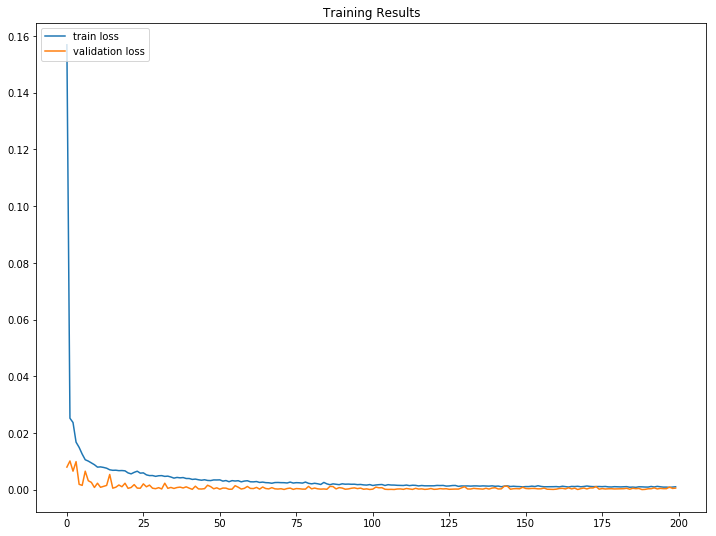

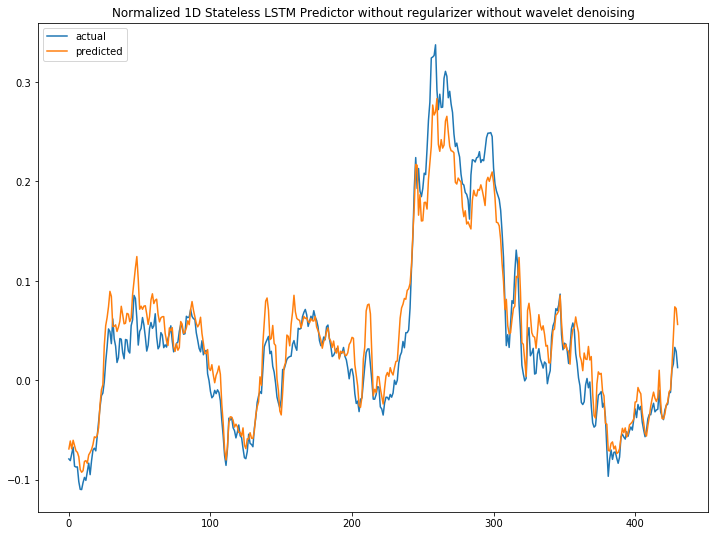

> Prediction vs Actual


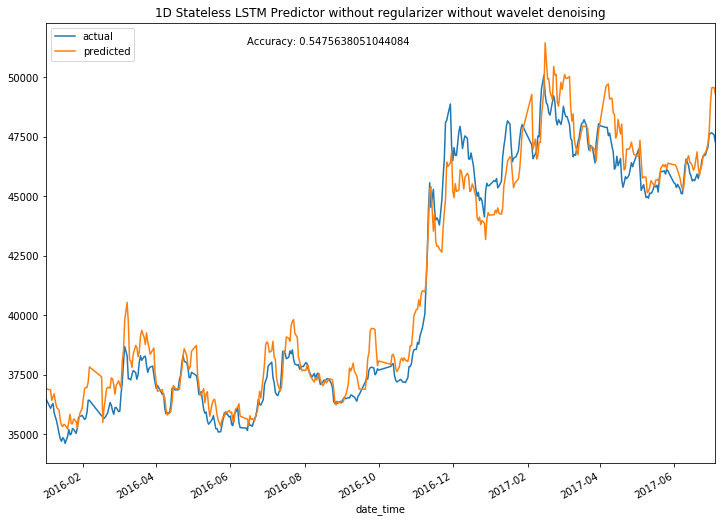

In [69]:
look_back = 64
model, history, actual, predicted = WaveletPredictor(
    time_interval="1D",
    wavelet_denoising=False,
    epochs=200, 
    network_structure=[9, look_back, 256, 256, 1],
    look_back=look_back,
    batch_size=128,
    technical_encoder=encoder
)

Test:  3955
Train: 20409
> X_train shape is (20409, 32, 1)
> encoded_X_train shape is (20409, 32, 8).
> X_test shape is (3955, 32, 1)
> encoded_X_test shape is (3955, 32, 8).
> Using regularizer: None
> Compilation Time :  0.02064061164855957
> Model Summary: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 32, 32)            5376      
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)               82432     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 129       
_________________________________________________________________
activation_5 (Activation)    (None, 1)                 0         
Total params: 87,937
Trainable params: 87,937
Non-trainable params: 0
_________________________________________________________________
None
Trai

20409/20409 [==============================] - 22s - loss: 2.1118e-04 - val_loss: 1.9989e-05
Epoch 68/100
20409/20409 [==============================] - 22s - loss: 2.0931e-04 - val_loss: 4.2022e-05
Epoch 69/100
20409/20409 [==============================] - 22s - loss: 2.0761e-04 - val_loss: 1.6885e-05
Epoch 70/100
20409/20409 [==============================] - 22s - loss: 2.0069e-04 - val_loss: 9.9902e-05
Epoch 71/100
20409/20409 [==============================] - 22s - loss: 1.9303e-04 - val_loss: 9.3953e-05
Epoch 72/100
20409/20409 [==============================] - 22s - loss: 1.9432e-04 - val_loss: 2.2999e-05
Epoch 73/100
20409/20409 [==============================] - 22s - loss: 1.9633e-04 - val_loss: 5.9135e-05
Epoch 74/100
20409/20409 [==============================] - 22s - loss: 1.8056e-04 - val_loss: 4.4583e-05
Epoch 75/100
20409/20409 [==============================] - 22s - loss: 1.7979e-04 - val_loss: 5.7742e-05
Epoch 76/100
20409/20409 [==============================] -

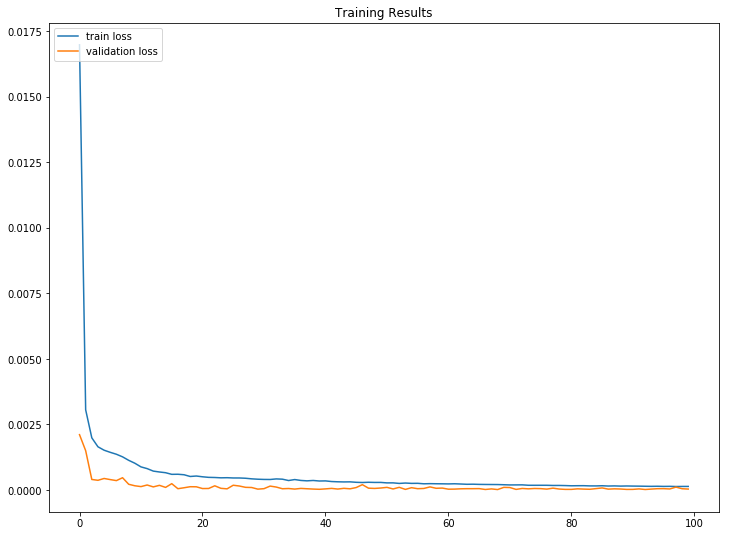

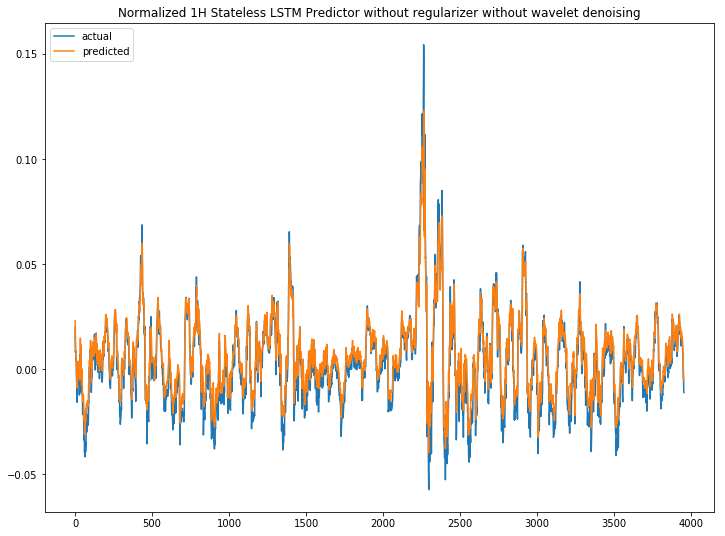

> Prediction vs Actual


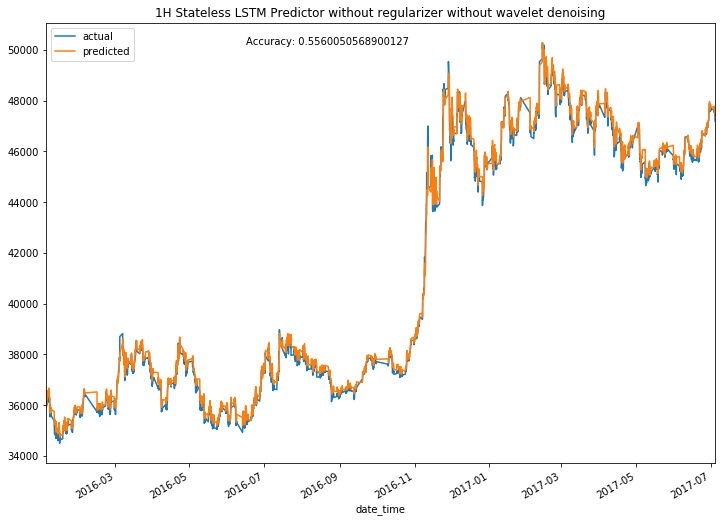

In [73]:
look_back = 32
history, autoencoder, encoder, decoder = AutoEncoderTraining("1H")
model, history, actual, predicted = WaveletPredictor(
    time_interval="1H",
    wavelet_denoising=False,
    epochs=100, 
    network_structure=[9, look_back, 128, 1],
    look_back=look_back,
    batch_size=512,
    technical_encoder=encoder
)

Train on 72144 samples, validate on 18037 samples
Epoch 1/300
72144/72144 [==============================] - 5s - loss: 0.0401 - val_loss: 0.0116
Epoch 2/300
72144/72144 [==============================] - 6s - loss: 0.0106 - val_loss: 0.0055
Epoch 3/300
72144/72144 [==============================] - 4s - loss: 0.0066 - val_loss: 0.0044
Epoch 4/300
72144/72144 [==============================] - 4s - loss: 0.0061 - val_loss: 0.0041
Epoch 5/300
72144/72144 [==============================] - 4s - loss: 0.0060 - val_loss: 0.0041
Epoch 6/300
72144/72144 [==============================] - 4s - loss: 0.0059 - val_loss: 0.0041
Epoch 7/300
72144/72144 [==============================] - 4s - loss: 0.0059 - val_loss: 0.0042
Epoch 8/300
72144/72144 [==============================] - 5s - loss: 0.0059 - val_loss: 0.0040
Epoch 9/300
72144/72144 [==============================] - 4s - loss: 0.0059 - val_loss: 0.0040
Epoch 10/300
72144/72144 [==============================] - 5s - loss: 0.0059 - val_lo

72144/72144 [==============================] - 4s - loss: 0.0049 - val_loss: 0.0036
Epoch 86/300
72144/72144 [==============================] - 4s - loss: 0.0049 - val_loss: 0.0035
Epoch 87/300
72144/72144 [==============================] - 4s - loss: 0.0049 - val_loss: 0.0036
Epoch 88/300
72144/72144 [==============================] - 4s - loss: 0.0049 - val_loss: 0.0036
Epoch 89/300
72144/72144 [==============================] - 4s - loss: 0.0049 - val_loss: 0.0038
Epoch 90/300
72144/72144 [==============================] - 4s - loss: 0.0049 - val_loss: 0.0035
Epoch 91/300
72144/72144 [==============================] - 4s - loss: 0.0049 - val_loss: 0.0036
Epoch 92/300
72144/72144 [==============================] - 4s - loss: 0.0049 - val_loss: 0.0036
Epoch 93/300
72144/72144 [==============================] - 4s - loss: 0.0049 - val_loss: 0.0036
Epoch 94/300
72144/72144 [==============================] - 4s - loss: 0.0049 - val_loss: 0.0036
Epoch 95/300
72144/72144 [=================

72144/72144 [==============================] - 4s - loss: 0.0030 - val_loss: 0.0024
Epoch 169/300
72144/72144 [==============================] - 4s - loss: 0.0030 - val_loss: 0.0025
Epoch 170/300
72144/72144 [==============================] - 4s - loss: 0.0030 - val_loss: 0.0024
Epoch 171/300
72144/72144 [==============================] - 4s - loss: 0.0030 - val_loss: 0.0025
Epoch 172/300
72144/72144 [==============================] - 4s - loss: 0.0030 - val_loss: 0.0025
Epoch 173/300
72144/72144 [==============================] - 4s - loss: 0.0030 - val_loss: 0.0025
Epoch 174/300
72144/72144 [==============================] - 4s - loss: 0.0030 - val_loss: 0.0024
Epoch 175/300
72144/72144 [==============================] - 4s - loss: 0.0030 - val_loss: 0.0024
Epoch 176/300
72144/72144 [==============================] - 4s - loss: 0.0030 - val_loss: 0.0025
Epoch 177/300
72144/72144 [==============================] - 4s - loss: 0.0030 - val_loss: 0.0024
Epoch 178/300
72144/72144 [=======

72144/72144 [==============================] - 4s - loss: 0.0028 - val_loss: 0.0023
Epoch 252/300
72144/72144 [==============================] - 4s - loss: 0.0028 - val_loss: 0.0024
Epoch 253/300
72144/72144 [==============================] - 4s - loss: 0.0028 - val_loss: 0.0024
Epoch 254/300
72144/72144 [==============================] - 4s - loss: 0.0028 - val_loss: 0.0024
Epoch 255/300
72144/72144 [==============================] - 4s - loss: 0.0028 - val_loss: 0.0023
Epoch 256/300
72144/72144 [==============================] - 4s - loss: 0.0028 - val_loss: 0.0024
Epoch 257/300
72144/72144 [==============================] - 4s - loss: 0.0028 - val_loss: 0.0023
Epoch 258/300
72144/72144 [==============================] - 4s - loss: 0.0028 - val_loss: 0.0024
Epoch 259/300
72144/72144 [==============================] - 4s - loss: 0.0028 - val_loss: 0.0024
Epoch 260/300
72144/72144 [==============================] - 4s - loss: 0.0028 - val_loss: 0.0024
Epoch 261/300
72144/72144 [=======

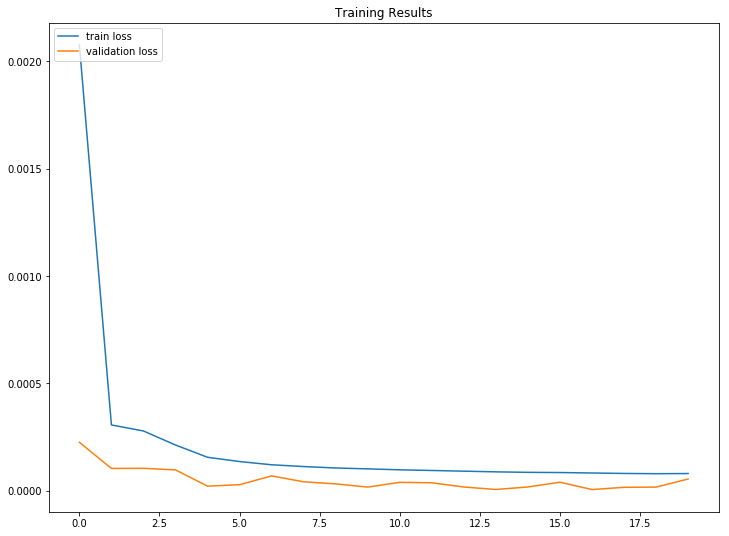

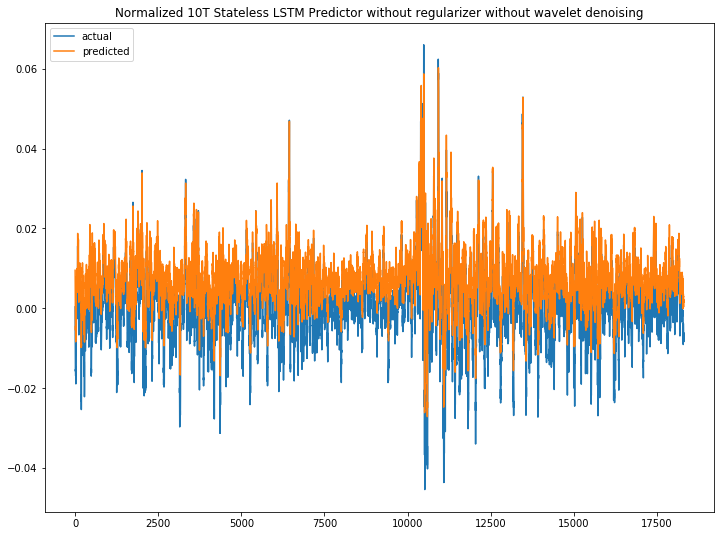

> Prediction vs Actual


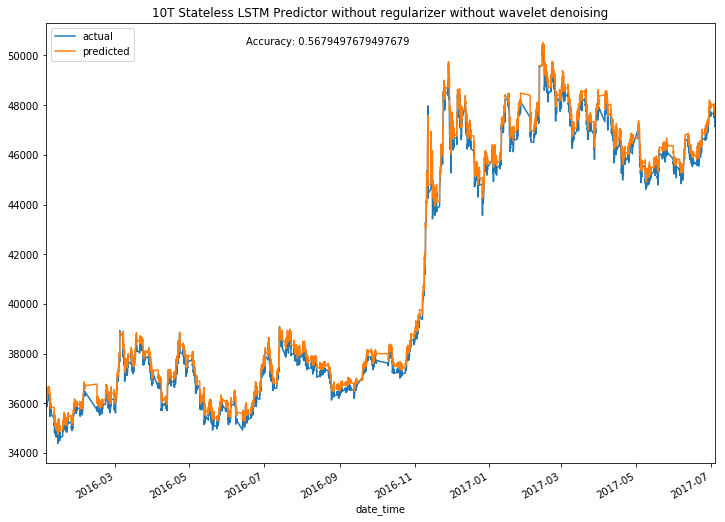

In [75]:
look_back = 32
history, autoencoder, encoder, decoder = AutoEncoderTraining("10T")
model, history, actual, predicted = WaveletPredictor(
    time_interval="10T",
    wavelet_denoising=False,
    epochs=20, 
    network_structure=[9, look_back, 128, 1],
    look_back=look_back,
    batch_size=512,
    technical_encoder=encoder
)